In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import functools
import math

In [2]:
seed = 42
batch_size = 64
num_epochs = 100
scale_factor = 4

In [3]:
hands_builder = tfds.builder('rock_paper_scissors')

In [4]:
hands_builder.download_and_prepare()

In [5]:
print(hands_builder.info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)



In [6]:
from plotting import plot_image_grid

/home/anonymous/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


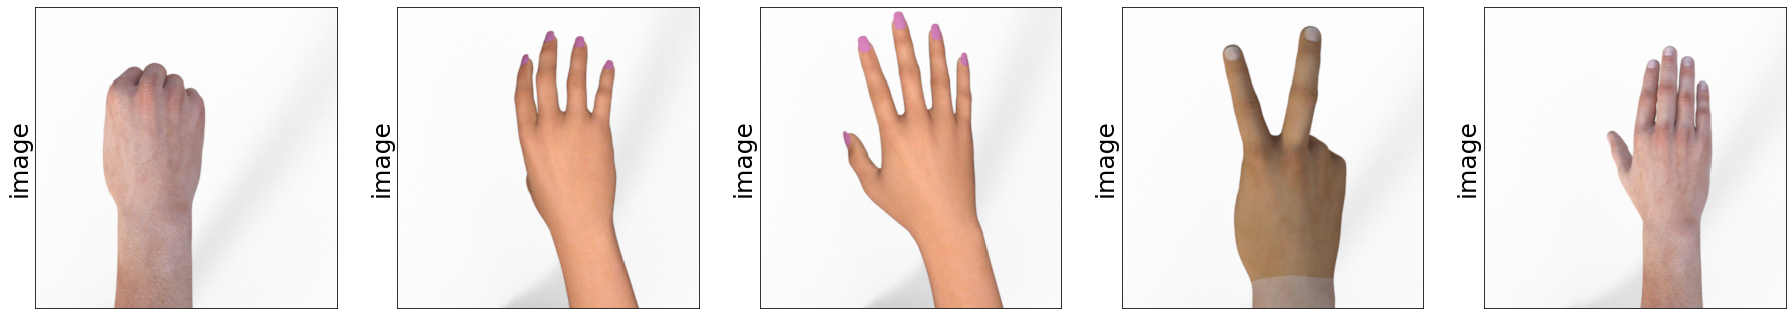

In [7]:
hands_val_dataset = hands_builder.as_dataset(split=tfds.Split.TEST)

num_show = 5
hands_val_dataset_iter = hands_val_dataset.batch(num_show).skip(1).__iter__()

batch = next(hands_val_dataset_iter)

fig = plot_image_grid([batch['image'].numpy()], titles=['image'], transpose=True)
fig.show()

In [8]:
def _prepare_data_fn(features, scale_factor=4, augment=True,
                    return_batch_as_tuple=True, seed=None):
    
    image = features['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    original_shape = tf.shape(image)
    original_size = original_shape[-3:-1]
    scaled_size = original_size // scale_factor
    
    original_size_mult = scaled_size * scale_factor
    
    if augment:
        original_shape_mult = (original_size_mult, [tf.shape(image)[-1]])
        if len(image.shape) > 3:
            original_shape_mult = ([tf.shape(image)[0]], *original_shape_mult)
        original_shape_mult = tf.concat(original_shape_mult, axis=0)
        
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed)
        image = tf.clip_by_value(image, 0.0, 1.0)
        
        random_scale_factor = tf.random.uniform([1], minval=1.0, maxval=1.2,
                                                dtype=tf.float32, seed= seed)
        scaled_height = tf.cast(tf.multiply(tf.cast(original_size[0], tf.float32),
                                           random_scale_factor),
                               tf.int32)
        scaled_width = tf.cast(tf.multiply(tf.cast(original_size[1], tf.float32),
                                          random_scale_factor),
                              tf.int32)
        scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))
        image = tf.image.resize(image, scaled_shape)
        image = tf.image.random_crop(image, original_shape, seed=seed)
    
    image_downscaled = tf.image.resize(image, scaled_size)
    
    original_size_mult = scaled_size * scale_factor
    image = tf.image.resize(image, original_size_mult)
    
    features = (image_downscaled, image) if return_batch_as_tuple else {'image': image_downscaled,
                                                                       'label': image}
    
    return features

In [9]:
def get_hands_dataset_for_superres(phase='train', scale_factor=4, batch_size=32,
                                  num_epochs=None, shuffle=True, augment=False,
                                  return_batch_as_tuple=True, seed=None):
    
    assert(phase=='train' or phase == 'test')
    
    prepare_data_fn = functools.partial(
        _prepare_data_fn, scale_factor=scale_factor, augment=augment,
        return_batch_as_tuple=return_batch_as_tuple, seed=seed
    )
    
    superres_dataset = hands_builder.as_dataset(
        split=tfds.Split.TRAIN if phase == 'train' else tfds.Split.TEST
    )
    
    superres_dataset = superres_dataset.repeat(num_epochs)
    
    if shuffle:
        superres_dataset = superres_dataset.shuffle(
            hands_builder.info.splits[phase].num_examples, seed=seed
        )
    
    superres_dataset = superres_dataset.batch(batch_size)
    superres_dataset = superres_dataset.map(prepare_data_fn, num_parallel_calls=4)
    superres_dataset = superres_dataset.prefetch(1)
    
    return superres_dataset

In [10]:
num_train_imgs = hands_builder.info.splits['train'].num_examples
num_val_imgs = hands_builder.info.splits['test'].num_examples

In [11]:
#num_train_imgs

In [12]:
#num_val_imgs

In [13]:
train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(num_val_imgs / batch_size)

In [14]:
input_shape = hands_builder.info.features['image'].shape

In [15]:
input_shape

(300, 300, 3)

In [16]:
train_hands_dataset = get_hands_dataset_for_superres(
    phase='train', scale_factor=scale_factor, batch_size=batch_size, 
    num_epochs=num_epochs, augment=True, shuffle=True, seed = seed
)

val_hands_dataset = get_hands_dataset_for_superres(
    phase = 'test', scale_factor=scale_factor, batch_size=batch_size,
    num_epochs=1, augment=False, shuffle=False, seed=seed
)

/home/anonymous/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


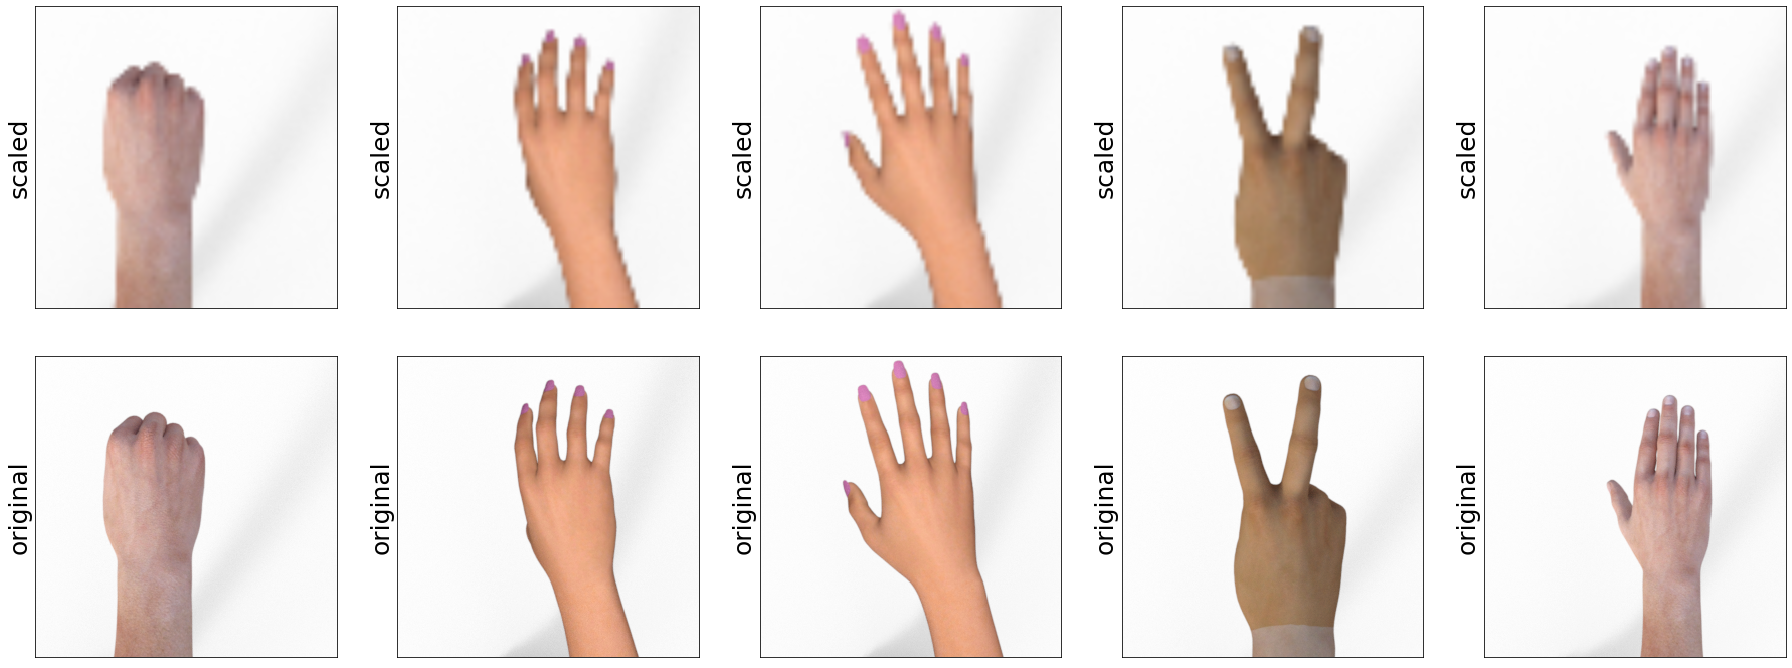

In [17]:
val_hands_dataset_show = val_hands_dataset.take(1)
val_images_input, val_images_target = next(val_hands_dataset_show.__iter__())
val_images_input = val_images_input[num_show: (num_show*2)]
val_images_target = val_images_target[num_show: (num_show * 2)]

val_images_input_resized = tf.image.resize(val_images_input, tf.shape(val_images_target)[1:3])
val_psnr_result = tf.image.psnr(val_images_target, val_images_input_resized, max_val=1.)

figure = plot_image_grid([val_images_input_resized.numpy(), val_images_target.numpy()],
                         titles=['scaled', 'original'], transpose=True)
figure.show()

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, Conv2DTranspose

In [19]:
Upscale = lambda name: Lambda(
    lambda images: tf.image.resize(images, (300,300)), 
    name=name)

In [20]:
#tf.shape

In [21]:
def simple_dae(inputs, kernel_size=3, filters_orig=16, layer_depth=4):
    
    filters = filters_orig
    x = inputs
    
    for i in range(layer_depth):
        x = Conv2D(filters = filters, kernel_size=kernel_size,
                  activation='relu', strides=2, padding='same',
                  name='enc_conv{}'.format(i))(x)
        filters = min(filters * 2, 512)
        
    for i in range(layer_depth):
        filters = max(filters // 2 , filters_orig)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,
                           activation='relu', strides=2, padding='same',
                           name='dec_deconv{}'.format(i))(x)
    
    decoded = Conv2D(filters = input_shape[-1], kernel_size=1,
                    activation='sigmoid', padding='same', name='dec_output')(x)
    
    return decoded

In [22]:
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize(images[0], (300,300)), 
    name=name)

In [23]:
def train_for_superres(inputs, kernel_size=3, filters_orig=16, layer_depth = 4):
    resized_inputs = Upscale(name='upscale_input')(inputs)
    decoded = simple_dae(resized_inputs, kernel_size, filters_orig, layer_depth)
    decoded = ResizeToSame(name='dec_output_scale')(decoded)
    
    return decoded

In [24]:
kernel_size  =  4
filters_orig = 32
layer_depth  =  4

In [25]:
inputs = Input(shape=(None, None, input_shape[-1]))
decoded = train_for_superres(inputs, kernel_size, filters_orig, layer_depth)

In [26]:
autoencoder = Model(inputs, decoded)

In [27]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
upscale_input (Lambda)       (None, 300, 300, 3)       0         
_________________________________________________________________
enc_conv0 (Conv2D)           (None, 150, 150, 32)      1568      
_________________________________________________________________
enc_conv1 (Conv2D)           (None, 75, 75, 64)        32832     
_________________________________________________________________
enc_conv2 (Conv2D)           (None, 38, 38, 128)       131200    
_________________________________________________________________
enc_conv3 (Conv2D)           (None, 19, 19, 256)       524544    
_________________________________________________________________
dec_deconv0 (Conv2DTranspose (None, 38, 38, 256)       104883

In [28]:
psnr_metric = functools.partial(tf.image.psnr, max_val=1.)
psnr_metric.__name__ = 'psnr'

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./graph'),
]

optimizer = tf.optimizers.Adam(learning_rate=1e-4)
autoencoder.compile(optimizer=optimizer, loss='mae', metrics=[psnr_metric, 'accuracy'])

autoencoder.fit(train_hands_dataset, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch, 
               validation_data=val_hands_dataset, validation_steps=val_steps_per_epoch,
               callbacks=callbacks)

Train for 40 steps, validate for 6 steps
Epoch 1/100
40/40 [==============================] - 739s 18s/step - loss: 0.3624 - psnr: 8.2895 - accuracy: 0.9650 - val_loss: 0.1579 - val_psnr: 12.9316 - val_accuracy: 0.9995
Epoch 2/100
40/40 [==============================] - 654s 16s/step - loss: 0.2097 - psnr: 10.4277 - accuracy: 0.9494 - val_loss: 0.1378 - val_psnr: 13.6287 - val_accuracy: 0.9298
Epoch 3/100
40/40 [==============================] - 655s 16s/step - loss: 0.1925 - psnr: 11.2346 - accuracy: 0.9545 - val_loss: 0.1191 - val_psnr: 13.2269 - val_accuracy: 0.9140
Epoch 4/100
40/40 [==============================] - 654s 16s/step - loss: 0.1960 - psnr: 11.3716 - accuracy: 0.8517 - val_loss: 0.1293 - val_psnr: 14.8138 - val_accuracy: 0.8438
Epoch 5/100
40/40 [==============================] - 656s 16s/step - loss: 0.1760 - psnr: 12.1358 - accuracy: 0.8410 - val_loss: 0.1055 - val_psnr: 14.5370 - val_accuracy: 0.8623
Epoch 6/100
40/40 [==============================] - 737s 18s/ste

In [29]:
autoencoder.save('dae_model.h5')